# Lab 4: Unsupervised Learning

# Overview

In Lab 2, we learned how to use linear regression to study whether certain features are significant in explaining and predicting an observed outcome. In Lab 3, we applied ensemble methods to refine our predictions. 

In this notebook, we shift the focus from prediction to exploration. The reality is that most available data in the world is unlabelled and needs to be understood before we can form a testable hypothesis and before it is suitable for predictive analyses.

That's where unsupervised learning comes in! Unsupervised learning methods are a set of techniques designed to <i>explore</i> the data rather than predict outcomes. There are many unsupervised learning methods (that you can learn more about how to use in Python <a href="http://scikit-learn.org/stable/unsupervised_learning.html">here</a>), but the most commonly-used method is cluster analysis (with greater theoretical detail described <a href="https://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf">here</a>). 

Here's a look ahead at what we'll be doing in this notebook:

1. Load data and packages
2. Run k-means algorithm to create clusters
3. Validate our assumptions
4. Evaluate our results

# What is Cluster Analysis?

Conducting cluster analysis is what it sounds like: partitioning your data into sub-groups (<b>clusters</b>) based on similar characteristics and then analyzing these clusters of similar observations. Clustering is an intuitive and visual way to understand the various <b>sub-groups</b> or <b>segments</b> that make up the population of your data.

There are numerous established clustering methods, including 

1. Hierarchial clustering
2. K-means clustering
3. Expectation-maximization clustering

...and much more! The difference across various methods lies in <i>how</i> clusters are formed. For example, clusters can be computed based on links/relationships (<i>e.g.</i>, hierarchial clustering) or based on distances between observations (that proxy for dis/similarities, <i>e.g.</i>, k-means clustering).

In this lab, we'll walk through a few examples of how to use K-means clustering to <b>partition</b> or <b>segment</b> the Kiva data into clusters.

# Step 1: Import and Merge Data

As you've seen in the previous notebooks, we'll start by importing the relevant data and packages:

In [32]:
## Import packages
import pandas as pd
import numpy as np

## Import packages for K-Means clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Import packages for plotting the clusters
import matplotlib.pyplot as plt
from matplotlib import style

## Import the raw Kiva data
data_path = '~/Desktop/Delta Analytics/Intro to ML/Kiva Data/'
loans_full = pd.read_csv(data_path + "loans_full.csv", index_col = 0, low_memory = False)
loans_details = pd.read_csv(data_path + "loans_details.csv", index_col = 0, low_memory = False)

## Merge the Kiva data 
additional_columns = loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')

# Step 2: Partitioning Your Data in Clusters

Now that we have our data set up, we can begin partitioning our data into smaller clusters based on a few features. For example, we can partition our data by groups of borrowers or by groups of lenders. Let's think about a few relevant features.

As a potential borrower or lender, what would be interesting to learn about types of borrowers or lenders? In the previous notebooks, we explored a number of interesting ideas, including how much a borrower should ask to borrow and the time it takes to fund a loan. So if we partition borrowers into distinct groups based on, for example, how many lenders they attract, will we be able to learn anything about their success in attracting funding?

In [33]:
## Select a few numeric columns that may be relevant to cluster by
nums = df[['funded_amount', 'lender_count', 'loan_amount', 'terms.repayment_term', 'borrower_count']]
X = np.array(nums)

<b>You now have a few features to consider clustering observations by. So how does clustering work?</b>

Mechanically, clusters based on K-means clustering are formed in the following process:

1. Observations are <i>randomly assigned</i> to a cluster
2. The center point of these <i>random</i> groups is determined
3. Observations are reassigned to a cluster where the center is closest to them
4. Observations are reassigned to a cluster where the center is closest to them
5. Observations are reassigned to a cluster where the center is closest to them
6. Observations are reassigned to a cluster where the center is closest to them
7. [...]
8. The process repeats until no observations shuffle around anymore, and each observation is assigned to exactly one cluster

In other words, until the distance beween an observation and their closest center point is minimized, observations are constantly being reassigned to clusters. Luckily, the <b>sklearn</b> K-means package is simple to use and does the computational heavy-lifting for you:

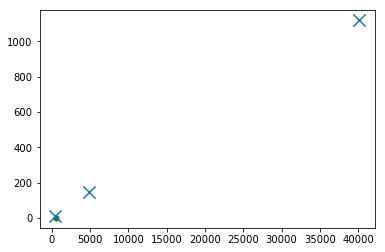

In [34]:
## Fit K-Means for the selected variables: 
## funded_amount, lender_count, loan_amount, terms.repayment_term, borrower_count
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_
colors = ["g.","r.","c."]

## Plot funded amount, lender count
for i in range(1):
    plt.plot(X[i][2],X[i][1],colors[labels[i]],markersize=10)
    plt.scatter(centroid[:,0],centroid[:,1], marker = "x", s=150, linewidths = 5, zorder =10)
    plt.show()

# Step 3: Cluster Evaluation

Let's break down step by step what the above chunk of code is actually doing and assess some of the factors worth considering as you form a cluster analysis.

# Determining k

In [35]:
## Define the number of clusters you want
kmeans = KMeans(n_clusters=3)

While this line of code is syntactically simple (set the number of clusters to 3), <b>determining the appropriate number of clusters (k) is actually one of the most challenging aspects of cluster analysis.</b> There are many sophisticated statistical methods proposed to determine k (for example, <a href="http://cs.fit.edu/~pkc/papers/ictai04salvador.pdf">the elbow method</a>, the silhouette method, information criterion approach, cross validation, among others).

But there is no hard and fast rule that the unsupervised learning community agrees on to determine k. This is largely driven by the fact that the desired number of clusters will always vary depending on your data and what you are trying to assess.

<b>Is it possible to have too many clusters?</b>

While it may be attractive to take a granular approach and partition your observations in many sub-groups, having too many clusters may defeat the value in clustering as a mechanism to understand natural patterns in groups; consider the extreme example of treating each data point as its own cluster. That would tell you nothing new!

<b>So how do I validate the appropriate number of clusters?</b>

The <b>elbow method</b> mentioned above is a simple, intuitive check. What the elbow method does is this:

1. Run the k-means algorithm over your dataset for a range of values (<i>e.g.,</i> let k be between 1 and 10 inclusive)
2. For each value of k, calculate the sum of squared errors (see Lab 2 for a refresher)

Check out a Python implementation of the elbow method on the Kiva data below:

In [36]:
## Elbow method code here

## Plot of elbow method results here

The elbow method is a reasonable check to perform when the data is reasonably clustered to begin with. But it's possible that your data may not be very clustered. For example, if we see a smooth curve rather than a clear elbow in the plot above, then it's not very clear what the optimal value of k is. Another method, such as <b>the silhouette method</b>, may be more appropriate. <i>On that note, understand that not all data is suitable for cluster analysis. </i>

In this specific case, we have some idea of what a reasonable value of k is based on the elbow method, so let's proceed. To actually run the K-means algorithm using the sklearn package in Python, all you need to do is this:

In [28]:
## Fitting the data
## Recall that X is defined above as an array of features
kmeans.fit(X)

## Set the initial, random center points
centroid = kmeans.cluster_centers_

Let's re-evaluate the plot and understand what we can glean from it.

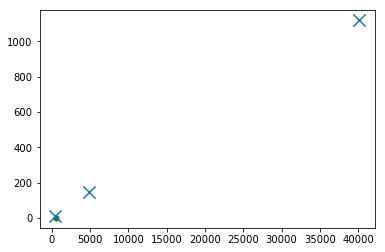

In [29]:
## Plot funded amount, lender count
for i in range(1):
    plt.plot(X[i][2],X[i][1],colors[labels[i]],markersize=10)
    plt.scatter(centroid[:,0],centroid[:,1], marker = "x", s=150, linewidths = 5, zorder =10)
    plt.show()

When we define three cluster groups, we can see that there [WIP]

In [49]:
## Placeholder - summary stats/plots of cluster-groups

# Step 4: Sanity Check Your Work

<b>Did we form meaningful clusters?</b>

Effective clustering results in clusters where observations in the same cluster are very similar to each other. Relatedly, observations in different clusters should be different from each other.

Statistically, this means we want as little within-cluster variation as possible. We can check that:

In [50]:
## Code here

<b>Can we perform statistical tests on cluster analyses?</b>

Remember that cluster analysis is done during the exploratory phase of your research project. That is, cluster analysis is meant to help you define your hypothesis, so applying the statistical tests you learned in Lab 2, such as paired t-tests and F-tests, wouldn't make much sense here since there is no hypothesis being tested. 

# Your Turn: Challenge Questions

1. How would you use cluster analysis to understand, cluster, and eventually predict fraudulent loans?